# Dog Bite Reports in New York City
### *An analysis on gender and breed*
#### Student Number: 100816849
#### Name: David Houle-Tymeczko

New York City has publicly available datasets on its website, one of which contains reports of dog bites. The earliest report comes from December 31, 2014, and the latest one comes from December 30, 2021. The raw file contains 22,663 dog bite incidents. Every row represents a single incident, with columns indicating the date, dog breed, age, gender, spayed/neutered status, and the borough and zip code where the bite took place, among others.

In Ontario, new pit bulls have been disallowed due to their penchant for biting. Such a strong stance against a specific breed suggests there must be statistical evidence to back it up. The gender of the dog could also play a role in their probability to bite since males are typically seen as more aggressive. Additionally, neutering and spaying seem like they would have an effect on a dog’s behaviour. I will explore the relationships between dog breeds, gender, and whether they were spayed or neutered, with respect to the number of incidents.

![Image of Dog Bite](https://worldanimalfoundation.org/wp-content/uploads/2023/01/The-Most-Crucial-Dog-Bite-Statistics-review.jpg)

## Methods
### Data Collection

<a href=https://www.kaggle.com/datasets/michaelbryantds/dog-bite-incidents>Kaggle</a>, a free online source for datasets, maintains a set of data from New York City containing reports of dog bite incidents since December 31, 2014 [1].

In [269]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# Load data into dataframe
data = pd.read_csv('DOHMH_Dog_Bite_Data.csv')
print(f'Number of rows: {data.shape[0]}')
data.head()

Number of rows: 22663


,UniqueID,DateOfBite,Species,Breed,Age,Gender,SpayNeuter,Borough,ZipCode
0,1,January 01 2018,DOG,UNKNOWN,NaN,U,False,Brooklyn,11220
1,2,January 04 2018,DOG,UNKNOWN,NaN,U,False,Brooklyn,NaN
2,3,January 06 2018,DOG,Pit Bull,NaN,U,False,Brooklyn,11224
3,4,January 08 2018,DOG,Mixed/Other,4,M,False,Brooklyn,11231
4,5,January 09 2018,DOG,Pit Bull,NaN,U,False,Brooklyn,11224


### Data Cleaning

The Species and UniqueID columns are pointless as the dataset only contains dog bites, and dataframes have their own indexing. Additionally, I will not be analyzing the ZipCode, Borough, or DateOfBite columns. Therefore, I removed these five columns.

In [270]:
# Drop pointless columns
data.drop(columns = ['UniqueID', 'Species', 'Borough', 'ZipCode', 'DateOfBite'], inplace=True)

Of the rows in the dataset, 12775 had missing values (NaN in pandas). These rows were removed before analyzing further. I also removed the rows in which the breed was entered as 'UNKNOWN' and the rows in which the gender was 'U' (unknown).

In [271]:
# original_length = data.shape[0]

# Remove all rows with missing values
data.dropna(inplace = True)

# missing = original_length - data.shape[0]
# print(f'Number of incomplete rows: {missing}')
# print(f'Number of complete rows: {original_length - missing}')

# Remove all rows with unknown breed
data = data[data.Breed != 'UNKNOWN']
# print(f'Number of rows with known breed: {data.shape[0]}')

# Remove all rows with unknown gender
data = data[data.Gender != 'U']
# print(f'Number of rows with known gender: {data.shape[0]}')

print(f'New number of rows: {data.shape[0]}')

New number of rows: 10871


Age in this dataset is actually plaintext, with an 'M' or 'm' indicating that the age is in months. There are also rows with a number followed by a 'Y' or 'y', presumably referring to age in years. Most of the rows contain ages with a simple number, indicating age in years.

However, there are 341 values that do not fall into any of these cases.

Upon further investigation, some of these exceptions end with a 'W' for weeks or a ' YRS' for years.

In [272]:
# Boolean Series to be used for filtering data by age formats
number_only_filter = data.Age.str.contains(r'^\d+$')
number_months_filter = data.Age.str.contains(r'^\d+[Mm]$')
number_y_filter = data.Age.str.contains(r'^\d+[Yy]$')

number_only = data.Age[number_only_filter].shape[0]
number_months = data.Age[number_months_filter].shape[0]
number_y = data.Age[number_y_filter].shape[0]
other_count = data.shape[0] - number_only - number_months - number_y

print(f'Number: {number_only}, Number with M: {number_months}, Number with Y: {number_y}, Other: {other_count}')

# Taking a look at the other values
other = data.Age[~number_only_filter][~number_months_filter][~number_y_filter]
other.head()

Number: 9713, Number with M: 584, Number with Y: 229, Other: 345


107      10W
120     7-8M
325    7 YRS
473    5 YRS
489    2 YRS
Name: Age, dtype: object

The other 341 rows actually contain a variety of age formats. Therefore, I removed them as they would add unncessary complexity for only a small number of data points. 

Converted months to years and made all ages numeric.

In [273]:
data = data[~data.index.isin(other.index)]
print(f'Updated number of rows: {data.shape[0]}')

pd.set_option('display.precision', 2)

# Converts string to float
def convert(n):
    if re.match(r'\d+[Mm]', n) != None:
        return float(n.rstrip('Mm'))/12
    if re.match(r'\d+[Yy]', n) != None:
        return float(n.rstrip('Yy'))
    return float(n)
data.Age = data.Age.map(convert)
data.Age.head()


Updated number of rows: 10526


3     4.0
5     4.0
8     5.0
9     3.0
11    7.0
Name: Age, dtype: float64

## Analyses
I will explore the relationships between dog breed, age, gender, and number of incidents.

### Distributions

The figure below (Fig 1.) shows the age distribution of the dogs. As one might expect, the majority of incidents occurred with younger dogs (under 5 years of age). 

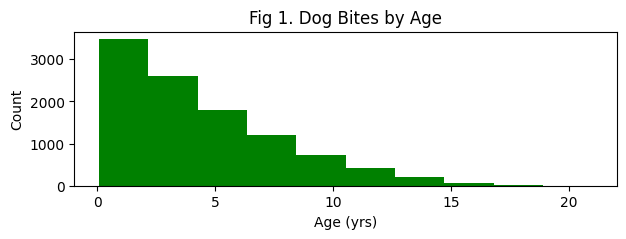

In [274]:
h = data.Age.plot.hist(bins=10, figsize=(7,2), grid=False, title='Fig 1. Dog Bites by Age', color='green')
plt.xlabel('Age (yrs)')
plt.ylabel('Count')
plt.show(h)

Further analysis shows that the average age is 4.59 years with a standard deviation of 3.34, meaning most of the ages are captured within a 1 year to 8 year interval. In terms of dogs, this represents a decent spread. 

The ages range from about a month old to 21 years. The greatest age being 21 could be an error, as the likelihood of a dog at a nearly world-record age biting someone seems quite low.

In [275]:
ds = data.Age.describe()
mean = ds['mean']
std = ds['std']
max = ds['max']
min = ds['min']
print(f'Mean: {round(mean,2)}')
print(f'Standard deviation: {round(std,2)}')
print(f'Max: {round(max,2)}')
print(f'Min: {round(min,2)}')

Mean: 4.59
Standard deviation: 3.34
Max: 21.0
Min: 0.08


Of the incidents in the dataset, the majority of the dogs were male. Figure 2 below shows the distribution of gender.

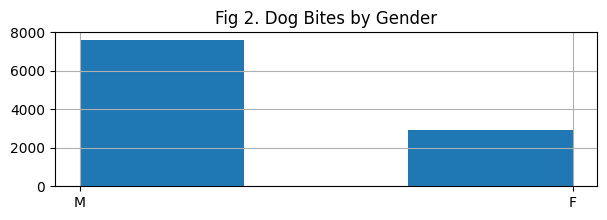

In [276]:
h = data.Gender.hist(bins=3,figsize = (7,2))
plt.title('Fig 2. Dog Bites by Gender')
plt.show(h)

### Gender and Whether Spayed/Neutered on Number of Incidents
The number of incidents appears to be completely unaffected by spaying or neutering. In each group, the number of males is more than double the number of female counterparts.

In [277]:
data.groupby(['Gender', 'SpayNeuter']).size().unstack()

SpayNeuter,False,True
Gender,,
F,1317,1589
M,3778,3842


### Breed and Number of Incidents
Unfortunately, the breeds were not entered in a standardized manner. Some breeds may have been entered twice using different formats, which means some data was lost in examining the number of dogs of each breed.

In [278]:
breeds = data.groupby('Breed').size().sort_values(ascending=False)
breeds.head()

Breed
Pit Bull                                1322
Shih Tzu                                 446
American Pit Bull Mix / Pit Bull Mix     437
German Shepherd                          345
Mixed/Other                              317
dtype: int64

Pit bulls and pit bull mixes appear to be far more common than other breeds in this dataset. I added up all the breeds containing the words 'pit bull' into a single column and compared it to .

In [279]:
# Collecting all pit bull variants into a single column
num_pit_bulls = 0
for breed in breeds.index:
    if re.search(r'pit bull', breed, re.IGNORECASE) != None:
        num_pit_bulls += breeds[breed]
        breeds.drop(breed, inplace=True)
breeds['Pit Bull'] = num_pit_bulls

# Collecting insignificant breeds into one column
other = 0
for breed in breeds.index:
    if breeds[breed] < 200 or breed in ('MIXED', 'MIXED BREED', 'Mixed/Other'):
        other += breeds[breed]
        breeds.drop(breed, inplace=True)
breeds['Other'] = other

breeds.sort_values(ascending = False)

Breed
Other                6616
Pit Bull             2326
Shih Tzu              446
German Shepherd       345
Chihuahua             301
Yorkshire Terrier     274
Maltese               218
dtype: int64

Figure 3 represents the number of dog bites broken up by breed. There are a wide variety of dog breeds in the dataset, causing the 'Other' category to dwarf the others. However, the 'Pit Bull' category is still quite significant.

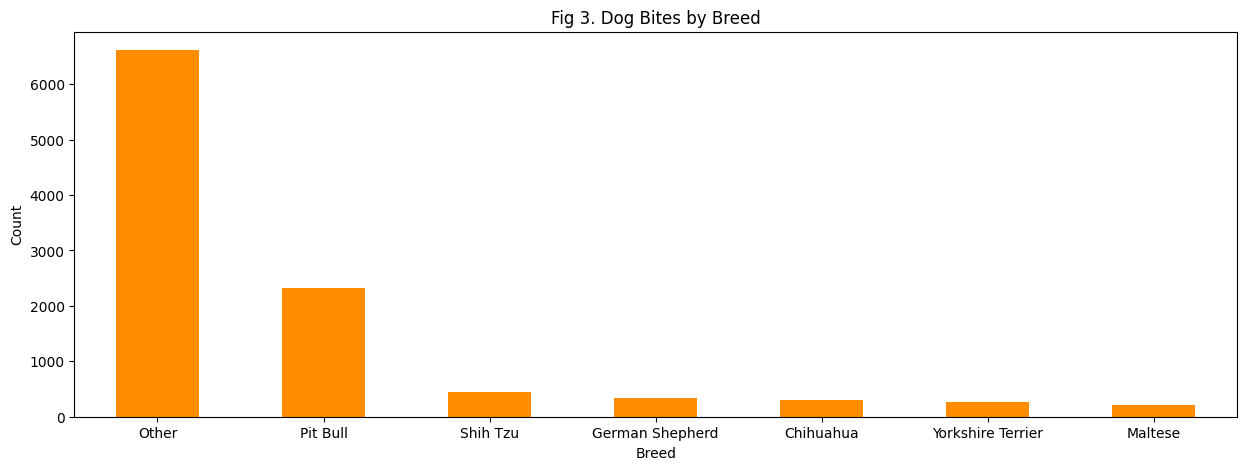

In [280]:
breeds.sort_values(ascending=False, inplace=True)
bar_plot = breeds.plot.bar(figsize=(15,5), title='Fig 3. Dog Bites by Breed', color='darkorange')
plt.xlabel('Breed')
plt.xticks(rotation = 0)
plt.ylabel('Count')
plt.show(bar_plot)

### Sex and Breed on Number of Incidents
The table below indicates that gender and breed have a great effect on the number of incidents. The males in the 'Other' category are greatest in number (4855), while the highest number of dogs in an individual breed comes from males in 'Pit Bull' (1606).

In [281]:
# Change the actual dataframe to mimick the breeds Series
def change_breed(breed):
    if re.search(r'pit bull', breed, re.IGNORECASE) != None:
        return 'Pit Bull'
    elif breed in breeds.index:
        return breed
    else:
        return 'Other'
data.Breed = data.Breed.map(change_breed)
grouped_data = data.groupby(['Breed', 'Gender']).size().unstack()
grouped_data


Gender,F,M
Breed,,
Chihuahua,85,216
German Shepherd,95,250
Maltese,60,158
Other,1761,4855
Pit Bull,720,1606
Shih Tzu,117,329
Yorkshire Terrier,68,206


Figure 4 illustrates the effect of gender and breed:

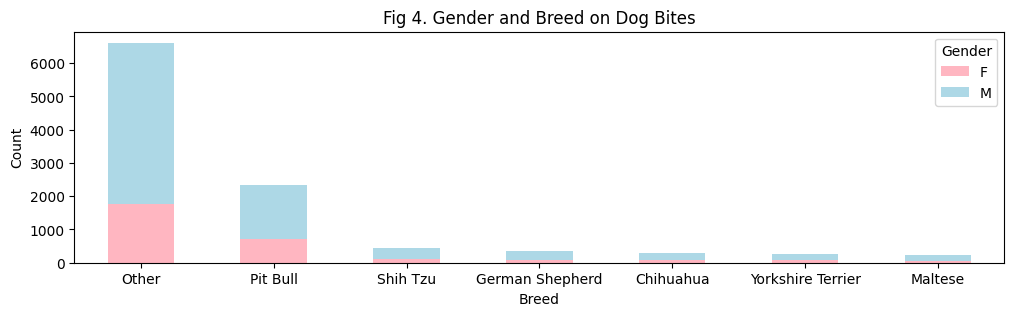

In [282]:
plot = grouped_data.sort_values(ascending=False, axis='index', by='M').plot.bar(stacked=True, color=('lightpink','lightblue'), 
figsize=(12,3), title='Fig 4. Gender and Breed on Dog Bites')
plt.xticks(rotation=0)
plt.xlabel('Breed')
plt.ylabel('Count')
plt.show(plot)

## Discussion

In this assignment, I analyzed a dataset of dog bite reports in New York City, focusing on the relationships between dog breeds, gender, spayed/neutered status, and how they affect the number of incidents. Both gender and breed affected the number of reports, with male pit bull variants being the largest group. Over twice as many male dogs bit people than female dogs. The ages were mostly in the younger range, probably because younger dogs have more energy and not as much training. Whether a dog was spayed or neutered had no effect on its tendency to bite. These results suggest that discouraging people from owning pit bulls or male dogs or encouraging such owners to properly train their dogs, would lessen the number of dog bite incidents. Therefore, if they have not already done so, New York City should consider making policies based on these findings.

## References
1. Source data - https://www.kaggle.com/datasets/michaelbryantds/dog-bite-incidents
2. Pandas for data manipulation
3. Matplotlib for data visualization
4. Re for regular expressions, used for parsing the data